In [13]:
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from astropy.io import fits
from POSEIDON.constants import R_Sun, R_J, M_J
import numpy as np
from spectres import spectres
from datetime import datetime
from matplotlib.pyplot import *
import time
import pickle
from matplotlib.pyplot import cm
from array import *
from astropy.io import fits
import glob
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"
import matplotlib.pyplot as plt

# TODO:
### 1. Migrate plotting function into high res
### 2. Make tutorials

In [14]:
def get_coordinate_list(x_values, y_values):
    x, y = np.meshgrid(x_values, y_values)
    coordinates = np.dstack([x, y]).reshape(-1, 2)
    return [tuple(coord) for coord in coordinates]

2.3015650081441836


/tmp/ipykernel_925130/2872878392.py:46: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_logL_SNR" + str(date_time) + ".pdf", fmt="pdf")


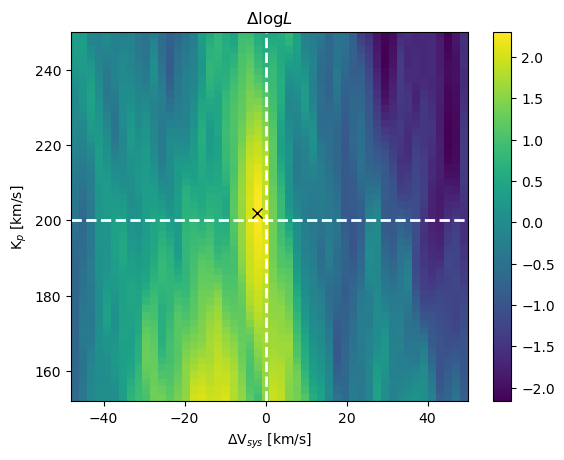

2.8475980770437035


/tmp/ipykernel_925130/2872878392.py:73: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_CCF_SNR" + str(date_time) + ".pdf", fmt="pdf")


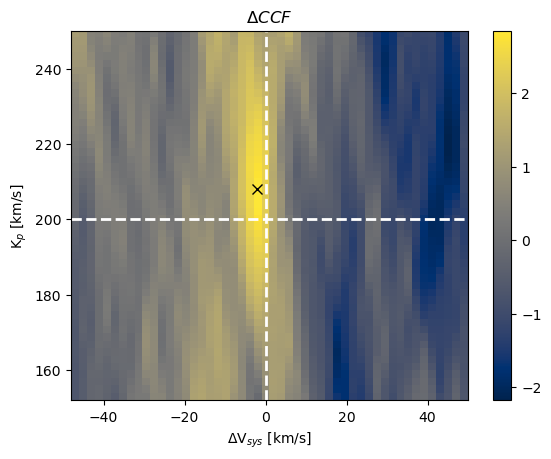

/tmp/ipykernel_925130/2872878392.py:87: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_logL_slice.pdf", fmt="pdf")


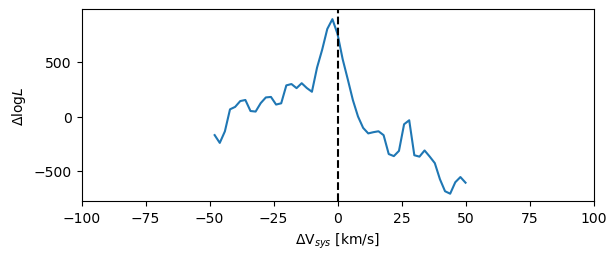

In [30]:
# output_path = "./CC_output/WASP-76b-injection-Na-7/"
# output_path = "./CC_output/WASP-121b/"
# output_path = "./CC_output/WASP-121b-injection/"
output_path = "./CC_output/WASP-121b/"
name = "WASP-121b"

K_p_arr, V_sys_arr, loglikelihood, CCF = pickle.load(
    open(output_path + "cross_correlation_results.pic", "rb")
)

K_p = 200
V_sys = 0  # True value

stdev_range_x = np.where((K_p_arr < K_p - 15) | (K_p_arr > K_p + 15))[0]
stdev_range_y = np.where((V_sys_arr < V_sys - 15) | (V_sys_arr > V_sys + 15))[0]
stdev_range = get_coordinate_list(stdev_range_x, stdev_range_y)

loglikelihood = loglikelihood - np.mean(loglikelihood)
stdev = np.std(loglikelihood[stdev_range])
maxx = (loglikelihood / stdev).max()
print(maxx)
loc = np.where(loglikelihood / stdev == maxx)


fig, ax = subplots()
cax = ax.imshow(
    loglikelihood / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    # interpolation="bilinear",
    origin="lower",
)

cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta $log$L$")

now = datetime.now()  # current date and time
date_time = now.strftime("%m_%d_%H_%M")

savefig(output_path + name + "_logL_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()

# CCF
CCF = CCF - np.mean(CCF)
stdev = np.std(CCF[stdev_range])
maxx = (CCF / stdev).max()
print(maxx)
loc = np.where(CCF / stdev == maxx)
fig, ax = subplots()
cax = ax.imshow(
    CCF / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    # interpolation="bilinear",
    cmap="cividis",
    origin="lower",
)
cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta CCF$")
savefig(output_path + name + "_CCF_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()


# slice at Kp
index = np.argmin(np.abs(K_p_arr - K_p))
slicee = loglikelihood[index]
plot(V_sys_arr, slicee)
axis([-100, 100, 1.1 * slicee.min(), 1.1 * slicee.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("$\Delta$log$L$")
axvline(x=V_sys, ls="--", color="black")
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(output_path + name + "_logL_slice.pdf", fmt="pdf")
show()
close()